# Packages

In [128]:
!pip install calplot
!pip install plotly-calplot

import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import date
import sqlite3
from datetime import timedelta
from plotly_calplot import calplot
import calplot
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# API Extraction

In [129]:
website = 'https://calendarific.com/api/v2/'
key = 'e937c7c03d3e9293144395a1ce4c958168b155f1' #insert your own API here
parameter = "holidays"
country_api = "za" #choose countries here

#For current year of usage
# yr_start_date = datetime.datetime.now().date().strftime("%Y-%m-%d")
yr_start_date = date.today()
a= date.today().strftime("%Y")
year_start = int(datetime.datetime.now().date().strftime("%Y"))
interval = 5 #yrs
year_end = year_start+interval+1 #Assumes a 5 year interval

'''
year_period = list of years
Adding another for the following reasons:

 Other year is added to get the possible leave deductions
 for the final December days as the leave interval potentially 
 rolls over into the new year

e.g. 
year_end = 2022

date = 2022-12-29
Leave interval = 5

You will need check the days from 2022-12-29 to 2023-01-02
to see if there are any potential annual leave deductions

'''
year_period = [x for x in range(year_start, year_end+1)]

print(year_period)


[2022, 2023, 2024, 2025, 2026, 2027, 2028]


# PANDAS DATAFRAMES

Creating two pandas dataframes

1. all South African holidays
2. all the dates within the specified period


In [130]:
#Lists for dataframe
calender = [] #calender date
name = [] #holiday name
holiday_type = [] #public holiday/observaence/
# country = []
description = [] #info

def holiday_data(year_period):

  """
  Functions takes data from website and adds to lists
  """

  for year in year_period: #extracts data for each year from API

    #full api key using parameters from above
    api = f"{website}{parameter}&?api_key={key}&country={country_api}&year={year}"
    response = requests.get(api)
    
    data = response.json()

    #transform data from json file making easier to work with
    holidays = data['response']['holidays']
    holidays[0]

    for i in range(len(holidays)): #adds to list

      calender.append(holidays[i]['date']["iso"][:10])
      name.append(holidays[i]['name'])
      holiday_type.append((holidays[i]["type"][0]))
      # country.append(holidays[i]["country"]["id"])
      description.append(holidays[i]["description"])

    check = calender[-1]
    print(check)

  return print("Lists Created")

holiday_data(year_period)

2022-12-31
2023-12-31
2024-12-31
2025-12-31
2026-12-31
2027-12-31
2028-12-31
Lists Created


## National Holiday Dataframe

In [131]:
def pandas_df(calender, name, holiday_type, desc):
  """
  Function creates data frame of holidays
  """

  #create dataframe using lists
  df = pd.DataFrame({
              "date": calender, 
              "name": name,
              "type":holiday_type,
                # "country": country,
                "description" : desc
                })
  
  from datetime import date 

  #adding day name to dataframe
  df.insert(1,"weekday", pd.to_datetime(calender, format = "%Y-%m-%d").strftime("%A"))

  #filters data showing only holidays after current date
  current = str(date.today())
  df = df[df["date"] >= current]

  return df 

#call out dataframe
df = pandas_df(calender, name, holiday_type, description)
df.head()

,date,weekday,name,type,description
20,2022-07-18,Monday,Nelson Mandela Day,Observance,Nelson Mandela Day is a observance in South Af...
21,2022-07-30,Saturday,Muharram/Islamic New Year,Muslim,Muharram is the first month of the Islamic cal...
22,2022-08-09,Tuesday,National Women's Day,National holiday,National Women's Day is a public holiday in So...
23,2022-09-23,Friday,September Equinox,Season,September Equinox in South Africa (Johannesburg)
24,2022-09-24,Saturday,Heritage Day,National holiday,Heritage Day is a public holiday in South Africa


## Calender Datatable

Basically a pandas df of all the dates from the last time the script was ran to the end of the chosen year

In [132]:
def create_datetable(year_start, year_end): 
  '''
  Function creates dataframe for all days within 
  period which contains the following data:
  1. Date 
  2. Day name
  3. type of day: weekday or weekend
  '''

  begin = yr_start_date
  end = f"{year_end}-12-31"
  df_days = pd.DataFrame({"date": pd.date_range(begin, end)})
  df_days['weekday'] = df_days['date'].dt.day_name()

  day_type = []

  for weekno in df_days["date"]:

    weekno = weekno.weekday()

    #weekdays index values is 0,1,2,3,4
    if weekno < 5:
      day_type.append("Weekday")
    else:  
        # 5 Sat, 6 Sun
      day_type.append("Weekend")

  df_days["weekday_type"] = day_type

  #Converts date column type to string
  df_days["date"] = df_days["date"].astype(str)

  return df_days

df_days = create_datetable(year_start, year_end)
df_days.head()

print(df_days.info())
print(df_days.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2360 entries, 0 to 2359
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          2360 non-null   object
 1   weekday       2360 non-null   object
 2   weekday_type  2360 non-null   object
dtypes: object(3)
memory usage: 55.4+ KB
None
         date    weekday weekday_type
0  2022-07-17     Sunday      Weekend
1  2022-07-18     Monday      Weekday
2  2022-07-19    Tuesday      Weekday
3  2022-07-20  Wednesday      Weekday
4  2022-07-21   Thursday      Weekday


# SQL Database

converts the two pandas dataframes into sql databases

## National SQL holiday database

In [133]:
# Creates database 
#Creates holiday date database

conn = sqlite3.connect('test_database')
c = conn.cursor()

c.execute('''CREATE TABLE IF NOT EXISTS holiday ( 
          date text, 
          day text, 
          name text,
          type text)
          ''')
conn.commit()

df.to_sql('holiday', conn, if_exists='replace', index = False)

c.execute('''  
SELECT * FROM holiday
          ''')

c.execute('''
          SELECT *
          FROM holiday
          ''')

holidays = c.fetchall()

for holiday in holidays[:5]:
  print(holiday)


('2022-07-18', 'Monday', 'Nelson Mandela Day', 'Observance', 'Nelson Mandela Day is a observance in South Africa')
('2022-07-30', 'Saturday', 'Muharram/Islamic New Year', 'Muslim', 'Muharram is the first month of the Islamic calendar and a time of remembrance or mourning.')
('2022-08-09', 'Tuesday', "National Women's Day", 'National holiday', "National Women's Day is a public holiday in South Africa")
('2022-09-23', 'Friday', 'September Equinox', 'Season', 'September Equinox in South Africa (Johannesburg)')
('2022-09-24', 'Saturday', 'Heritage Day', 'National holiday', 'Heritage Day is a public holiday in South Africa')


## Calender SQL database

In [134]:
#Creates calender date database

df_days.to_sql('datetable', conn, if_exists='replace', index = False)

c.execute('''
          SELECT *
          FROM datetable
          ''')

calender_days = c.fetchall()

for days in calender_days[:5]:
  print(days)

('2022-07-17', 'Sunday', 'Weekend')
('2022-07-18', 'Monday', 'Weekday')
('2022-07-19', 'Tuesday', 'Weekday')
('2022-07-20', 'Wednesday', 'Weekday')
('2022-07-21', 'Thursday', 'Weekday')


# EDA

## Total Number of Weekday Holidays

Text(0.5, 1.0, 'Total no. of weekday national holidays in South Africa for each year')

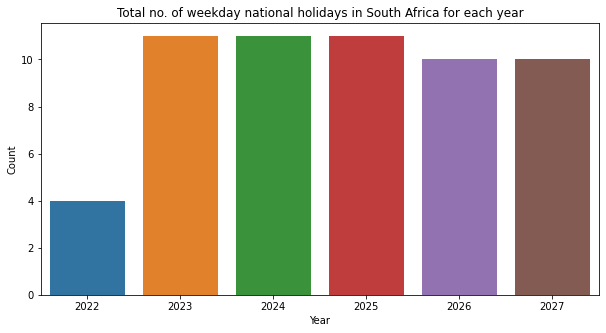

In [135]:
# This check which year has the most holidays

#Req for dataframe
holiday_years = []
holiday_years_count = []

for year in year_period:

  c.execute('''
            SELECT date, weekday, name
            FROM holiday
            WHERE type = "National holiday"
            AND weekday != "Sunday"
            AND weekday != "Saturday"
            AND date LIKE ?
            ''',(str(year)+"%",)          
            )

  holidays = c.fetchall()

  holiday_years.append(year)
  holiday_years_count.append(len(holidays))

ax = plt.figure(figsize=(10, 5))

df_holiday_all = pd.DataFrame({"Year" : holiday_years,
                              "Count" : holiday_years_count,
                              })

df_holiday_all = df_holiday_all[df_holiday_all["Year"] < year_end]

ax = sns.barplot(data = df_holiday_all, x = "Year", y = "Count")
ax.set_title("Total no. of weekday national holidays in South Africa for each year")


Above graph shows total number of weekday national holidays in South Africa for the next decade. Generally, the current year will have the least amount of weekday holidays as the script searches for all the holidays using the script's latest run date as the beginning date. 

That aside, weekday public holidays range is between 10-11 for the next 10 years.
Reasons for the difference in holiday count may be due to  some national holidays occuring on a Saturday. These national holidays are not celebrated on the nearest Monday (Unlike national holidays that occur on Sunday) and therefore does not count as a weekday holiday. 

Text(0.5, 1.0, 'Total no. of weekday national holidays in South Africa for each year excl. Dec. holidays')

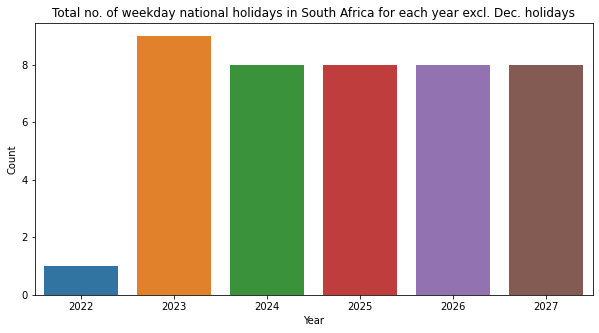

In [136]:
# This check which year has the most holidays
# Exluding the December holidays

#Req for dataframe
holiday_years_nodec = []
holiday_years_count_nodec = []

for year in year_period:

  c.execute('''
            SELECT date, weekday, name
            FROM holiday
            WHERE type = "National holiday"
            AND weekday != "Saturday"
            AND weekday != "Sunday"
            AND date LIKE ?
            AND date NOT LIKE "%-12-%"
            ''', (str(year)+"%",)
            )           

  holidays_nodec = c.fetchall()

  holiday_years_nodec.append(year)
  holiday_years_count_nodec.append(len(holidays_nodec))

df_holiday_nodec = pd.DataFrame({"Year" : holiday_years_nodec,
                              "Count" : holiday_years_count_nodec,
                              })

df_holiday_nodec = df_holiday_nodec[df_holiday_nodec["Year"] < year_end]

ax = plt.figure(figsize=(10, 5))

ax = sns.barplot(data = df_holiday_nodec, x = "Year", y = "Count")
ax.set_title("Total no. of weekday national holidays in South Africa for each year excl. Dec. holidays")

Many employees are required to take compulsory leave in December anyway. Therefore, I made a graph which shows total number of weekday national holidays in South Africa for the next decade. As mentioned previously, the current year will generally have the least amount of weekday holidays. 

The weekday public holiday range is between 8-9 days for the next 10 years which relatively minimal.


## Annual leave use optimisation

Finding out week day an employee should begin there leave so that they use the least amount of annual leave days for a given period. 

Generally, employees will use two strategies:
1. Have their leave period overlap a weekend. 
2. Have their leave period over a national public hoiday

Best approach is for the leave period to have both of these strategies.

### Only Weekends

Three leave periods were considered:

1. 3-day leave period
2. 5 day leave period
3. 7-day leave period

In [137]:
def weekends_only(day):

  '''
  Req to find out how many days left in current year

  diff fuction finds out the total no. days from today 
  i.e. 
  to end of year interval 

  timedelta in diff variables adds total days 
  from the year interval user requested
  '''
  end_current_yr_dt = f"{year_start}-12-31"
  end_current_yr_dt = datetime.datetime.strptime(end_current_yr_dt, '%Y-%m-%d').date()

  diff = (end_current_yr_dt + timedelta(weeks = 52*interval) - yr_start_date).days 

  # #functions used for determining 
  annual_leave_period = day # days
  # interval_end_day = yr_start_date  + timedelta(days = day_interval - 1)

  day_name = []
  total_cnt = []

  last_day = f"{year_end}-12-31"
  last_day = datetime.datetime.strptime(last_day, '%Y-%m-%d').date()


  for date in df_days["date"]:

      #convert date into datetime format
      date = datetime.datetime.strptime(date, '%Y-%m-%d').date()

      interval_end_day = date  + timedelta(days = annual_leave_period-1)

      if  interval_end_day <= last_day:

        c.execute('''
                  SELECT DISTINCT datetable.date, datetable.weekday
                  FROM datetable
                  LEFT JOIN holiday
                  ON datetable.date = holiday.date
                  WHERE datetable.date BETWEEN ? and ?
                  AND datetable.weekday_type = "Weekend"                              
                  ''',(str(date), str(interval_end_day),))
      
        a = c.fetchall()
        
        day_name.append(date)
        total_cnt.append(len(a))

      else:
        '''
        Req. so lists are same length
        But won't count cause we will be shortening it later
        '''
        total_cnt.append(0)

  awe = pd.DataFrame({"date": pd.date_range(yr_start_date, last_day)})
  awe['Count'] = total_cnt

  awe = awe[awe["date"].astype(str) <= str(year_end)]
  awe.tail()

  fig = plt.figure(figsize=(100,40))

  from plotly_calplot import calplot

  # creating the plot
  fig = calplot(awe, x = "date", y = "Count",
                month_lines_width=2,  
                month_lines_color="black",
                gap=1, 
                width = 1000,
                # total_height = 1100,
                title=f"Annual leave deduction for {day}-day leave period: Interactive",
                years_title = True,
                space_between_plots = 0.03,
                colorscale="sunset"
                )
  
  return fig.show()

In [138]:
weekends_only(3)

<Figure size 7200x2880 with 0 Axes>

Above shows a calender heatmap of the amount of days you may deduce your annual leave by for a 3-day leave period assuming no public holidays. 

It is recommended that you take leave between Thursday-Sunday for maximum effect.

In [139]:
weekends_only(5)

<Figure size 7200x2880 with 0 Axes>

Above shows a calender heatmap of the amount of days you may deduce your annual leave by for a 5-day leave period assuming no public holidays.  

It is recommended that you take leave between Wednesday-Friday for maximum effect.

In [140]:
weekends_only(7)

<Figure size 7200x2880 with 0 Axes>

Above shows a calender heatmap of the amount of days you may deduce your annual leave by for a 7-day leave period assuming no public holidays. 

Doesn't matter which day to take.

### Public Holidays + Weekends

Three leave periods were considered:

1. 3-day leave period
2. 5 day leave period
3. 7-day leave period

In [141]:
def public_holi_Weekend(day):

  '''
  Req to find out how many days left in current year

  diff fuction finds out the total no. days from today 
  i.e. 
  to end of year interval 

  timedelta in diff variables adds total days 
  from the year interval user requested
  '''
  end_current_yr_dt = f"{year_start}-12-31"
  end_current_yr_dt = datetime.datetime.strptime(end_current_yr_dt, '%Y-%m-%d').date()

  diff = (end_current_yr_dt + timedelta(weeks = 52*interval) - yr_start_date).days 

  # #functions used for determining 
  annual_leave_period = day # days
  # interval_end_day = yr_start_date  + timedelta(days = day_interval - 1)

  day_name = []
  total_cnt = []

  last_day = f"{year_end}-12-31"
  last_day = datetime.datetime.strptime(last_day, '%Y-%m-%d').date()


  for date in df_days["date"]:

      #convert date into datetime format
      date = datetime.datetime.strptime(date, '%Y-%m-%d').date()

      interval_end_day = date  + timedelta(days = annual_leave_period-1)

      if  interval_end_day <= last_day:

        c.execute('''
                  SELECT  datetable.date, holiday.weekday, holiday.name,holiday.type, datetable.weekday_type
                  FROM datetable
                  LEFT JOIN holiday
                  ON datetable.date = holiday.date
                  WHERE datetable.date BETWEEN ? and ?
                  AND (holiday.type = "National holiday" OR datetable.weekday_type = "Weekend")                       
                  ''',(str(date), str(interval_end_day),))
      
        a = c.fetchall()
        
        day_name.append(date)
        total_cnt.append(len(a))

      else:
        '''
        Req. so lists are same length
        But won't count cause we will be shortening it later
        '''
        total_cnt.append(0)

  awe = pd.DataFrame({"date": pd.date_range(yr_start_date, last_day)})
  awe['Count'] = total_cnt

  awe = awe[awe["date"].astype(str) <= str(year_end)]
  awe.tail()

  fig = plt.figure(figsize=(100,40))

  from plotly_calplot import calplot

  # creating the plot
  fig = calplot(awe, x = "date", y = "Count",
                month_lines_width=2,  
                month_lines_color="black",
                gap=1, 
                width = 1000,
                # total_height = 1100,
                title=f"Annual leave deduction for {day}-day leave period: Interactive",
                years_title = True,
                space_between_plots = 0.03,
                colorscale="sunset"
                )
  
  return fig.show()

In [142]:
public_holi_Weekend(3)

<Figure size 7200x2880 with 0 Axes>

Above shows a calender heatmap of the amount of days you may deduce your annual leave by for a 3-day leave period based on weekends and public holidays

Generally, best times to take leave is either Friday or Saturday.

High concentration of leave deductions occur in the months of April and December

In [143]:
public_holi_Weekend(5)

<Figure size 7200x2880 with 0 Axes>

Above shows a calender heatmap of the amount of days you may deduce your annual leave by for a 7-day leave period based on weekends and public holidays

Generally, best times to take leave is either Wednesday and Saturday. 
High concentration of leave deductions occur in the months of April and December

In [144]:
public_holi_Weekend(7)

<Figure size 7200x2880 with 0 Axes>

Above shows a calender heatmap of the amount of days you may deduce your annual leave by for a 7-day leave period based on weekends and public holidays

Generally, the strategy is to take leave in March/April or December where the leave period lies over 1-2 public holidays.

For some months: June, August and September, one can can take leave becausee at least one public holiday will lie in your leave period for those months. 

In [145]:
def public_holi_Weekend_nointeraction(day):

  '''
  Req to find out how many days left in current year

  diff fuction finds out the total no. days from today 
  i.e. 
  to end of year interval 

  timedelta in diff variables adds total days 
  from the year interval user requested
  '''
  end_current_yr_dt = f"{year_start}-12-31"
  end_current_yr_dt = datetime.datetime.strptime(end_current_yr_dt, '%Y-%m-%d').date()

  diff = (end_current_yr_dt + timedelta(weeks = 52*interval) - yr_start_date).days 

  # #functions used for determining 
  annual_leave_period = day # days
  # interval_end_day = yr_start_date  + timedelta(days = day_interval - 1)

  day_name = []
  total_cnt = []

  last_day = f"{year_end}-12-31"
  last_day = datetime.datetime.strptime(last_day, '%Y-%m-%d').date()


  for date in df_days["date"]:

      #convert date into datetime format
      date = datetime.datetime.strptime(date, '%Y-%m-%d').date()

      interval_end_day = date  + timedelta(days = annual_leave_period-1)

      if  interval_end_day <= last_day:

        c.execute('''
                  SELECT  datetable.date, holiday.weekday, holiday.name,holiday.type, datetable.weekday_type
                  FROM datetable
                  LEFT JOIN holiday
                  ON datetable.date = holiday.date
                  WHERE datetable.date BETWEEN ? and ?
                  AND (holiday.type = "National holiday" OR datetable.weekday_type = "Weekend")                       
                  ''',(str(date), str(interval_end_day),))
      
        a = c.fetchall()
        
        day_name.append(date)
        total_cnt.append(len(a))

      else:
        '''
        Req. so lists are same length
        But won't count cause we will be shortening it later
        '''
        total_cnt.append(0)

  df = pd.DataFrame({"date": pd.date_range(yr_start_date, last_day)})
  df['Count'] = total_cnt

  df = df[df["date"].astype(str) <= str(year_end)]

  fig = plt.figure(figsize=(100,40))

  from plotly_calplot import calplot

  # creating the plot
  fig = calplot(df, x = "date", y = "Count",
                month_lines_width=2,  
                month_lines_color="black",
                gap=1, 
                width = 1000,
                # total_height = 1100,
                title=f"Annual leave deduction for {day}-day leave period: Interactive",
                years_title = True,
                space_between_plots = 0.03,
                colorscale="sunset"
                )

  import calplot

  all_days = pd.date_range(yr_start_date, 
                          periods=len(df[df.columns[0]].tolist()), 
                          freq='D')
  
  events = pd.Series(df[df.columns[1]].tolist(), index=all_days)

  fig = plt.figure( )
  fig = calplot.calplot(events,
                  colorbar = True,
                  cmap='YlGn',
                  suptitle = f"Deductions to annual leave for {day}-day leave period"
                  )

  return fig
  


AttributeError: ignored

<Figure size 7200x2880 with 0 Axes>

<Figure size 432x288 with 0 Axes>

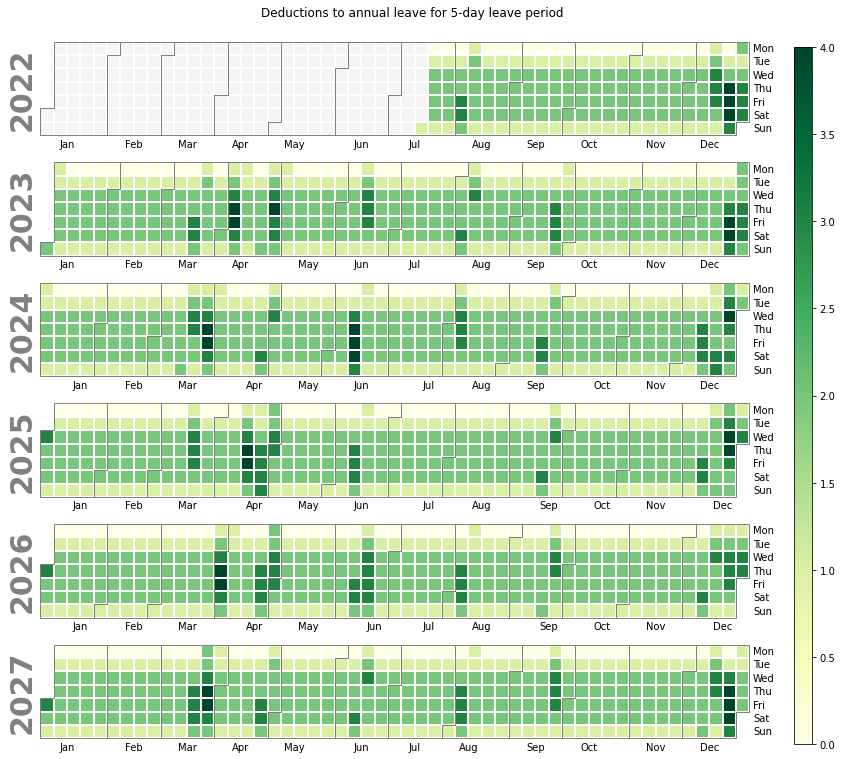

In [146]:
public_holi_Weekend_nointeraction(5)

Above is showing same results as a 5-day leave period but it is not interactive

# REFERENCES

##### Calenderific API Documentation
https://calendarific.com/api-documentation

##### Working with APIs
https://www.youtube.com/watch?v=hpc5jyVpUpw&list=LL&index=34

##### Convert pandas DataFrame into SQL in Python
https://www.geeksforgeeks.org/how-to-convert-pandas-dataframe-into-sql-in-python/

##### Change the Order of Columns in Pandas DataFrame
https://www.statology.org/pandas-change-column-order/

##### Convert Date String to Day of Week
https://stackoverflow.com/questions/16766643/convert-date-string-to-day-of-week

##### Pandas DataFrame to SQL
https://datatofish.com/pandas-dataframe-to-sql/

##### Get current date
https://www.delftstack.com/howto/python/python-current-year/

##### Simple plot with seaborn from a python dictionary
https://stackoverflow.com/questions/61852402/how-can-i-plot-a-simple-plot-with-seaborn-from-a-python-dictionary

##### Create a calendar table (date dimension) in pandas
https://stackoverflow.com/questions/47150709/how-to-create-a-calendar-table-date-dimension-in-pandas

##### convert pandas datetime to day, weekday, month
https://www.codegrepper.com/code-examples/python/df%5B%27weekday%27%5D+%3D+df%5B%27date%27%5D.dt.day_name%28%29

##### Python Check if Date is Weekend or Weekday

https://www.itsolutionstuff.com/post/python-check-if-date-is-weekend-or-weekday-exampleexample.html

#### SQL JOIN Tables
https://www.youtube.com/results?search_query=sql+join+tables

##### "Ambiguous Name Column” Error in SQL
https://towardsdatascience.com/how-to-solve-the-ambiguous-name-column-error-in-sql-d4c256f3d14c

##### Converting Date Difference to Integer 
https://stackoverflow.com/questions/53135789/convert-the-difference-between-two-dates-into-an-integer

##### Interactive Calendar Heatmaps with Python
https://python.plainenglish.io/interactive-calendar-heatmaps-with-plotly-the-easieast-way-youll-find-5fc322125db7

##### Continuous Color Scales and Color Bars in Python
https://plotly.com/python/colorscales/